In [1]:
import sqlite3
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#Read date and join
conn = sqlite3.connect('C:\\Users\\pklen\\Documents\\Sqlite\\DVADB_O.db')
df1 = pd.read_sql_query("select * from npi_outliers_only",conn)
df2 = pd.read_sql_query("select * from npi_outliers_opioid_day_supply",conn)
cols_to_use = df2.columns.difference(df1.columns)
#cols_to_use.append('npi')
cols_to_use = np.append(cols_to_use,['npi'])
#print(cols_to_use)
df = pd.merge(df1,df2[cols_to_use],  left_on='npi', right_on='npi', how='inner')
#df.to_csv("inner_join_table.csv", sep=',')
#print(df.columns)

In [39]:
#Select only columns we think important
#df.drop('index', axis=1, inplace=True)
#dcolumns1 =['total_claim_count','bene_count', 'Number_of_Group_Practice_members','opioid_claim_count','opioid_day_supply','opioid_bene_count','opioid_prescriber_rate', 'credential_md','credential_rn', 'credential_phd', 'credential_dds', 'credential_pa','credential_mba', 'specialty_description_anesthesiology','specialty_description_cardiology', 'specialty_description_dentist','specialty_description_dermatology','specialty_description_emergency_medicine','specialty_description_family_practice', 'specialty_description_gastroenterology', 'specialty_description_general_practice','specialty_description_general_surgery','specialty_description_geriatric_medicine','specialty_description_hematologyoncology','specialty_description_hospitalist','specialty_description_internal_medicine','specialty_description_interventional_pain_management','specialty_description_medical_oncology','specialty_description_nephrology','specialty_description_neurology','specialty_description_neurosurgery','specialty_description_nurse_practitioner','specialty_description_obstetrics__gynecology', 'specialty_description_ophthalmology','specialty_description_optometry','specialty_description_oral_surgery_dentist_only', 'specialty_description_orthopedic_surgery','specialty_description_otolaryngology', 'specialty_description_pain_management','specialty_description_physical_medicine_and_rehabilitation','specialty_description_physician_assistant','specialty_description_plastic_and_reconstructive_surgery','specialty_description_podiatry','specialty_description_psychiatry','specialty_description_psychiatry__neurology','specialty_description_pulmonary_disease','specialty_description_radiation_oncology','specialty_description_rheumatology','specialty_description_student_in_an_organized_health_care_educationtraining_program','specialty_description_urology','specialty_description_vascular_surgery']
#dcolumns2 =['total_claim_count','bene_count', 'opioid_claim_count','opioid_day_supply','opioid_bene_count','opioid_prescriber_rate', 'credential_md','credential_rn', 'credential_phd', 'credential_dds', 'credential_pa','credential_mba', 'specialty_description_anesthesiology','specialty_description_cardiology', 'specialty_description_dentist','specialty_description_dermatology','specialty_description_emergency_medicine','specialty_description_family_practice', 'specialty_description_gastroenterology', 'specialty_description_general_practice','specialty_description_general_surgery','specialty_description_geriatric_medicine','specialty_description_hematologyoncology','specialty_description_hospitalist','specialty_description_internal_medicine','specialty_description_interventional_pain_management','specialty_description_medical_oncology','specialty_description_nephrology','specialty_description_neurology','specialty_description_neurosurgery','specialty_description_nurse_practitioner','specialty_description_obstetrics__gynecology', 'specialty_description_ophthalmology','specialty_description_optometry','specialty_description_oral_surgery_dentist_only', 'specialty_description_orthopedic_surgery','specialty_description_otolaryngology', 'specialty_description_pain_management','specialty_description_physical_medicine_and_rehabilitation','specialty_description_physician_assistant','specialty_description_plastic_and_reconstructive_surgery','specialty_description_podiatry','specialty_description_psychiatry','specialty_description_psychiatry__neurology','specialty_description_pulmonary_disease','specialty_description_radiation_oncology','specialty_description_rheumatology','specialty_description_student_in_an_organized_health_care_educationtraining_program','specialty_description_urology','specialty_description_vascular_surgery']
dcolumns3 =['total_claim_count','bene_count', 'opioid_claim_count','opioid_day_supply','opioid_bene_count','opioid_prescriber_rate', 'credential_md','credential_rn', 'credential_phd', 'credential_dds', 'credential_pa','credential_mba']
#dcolumns3 =['total_claim_count','bene_count', 'Number_of_Group_Practice_members','opioid_claim_count','opioid_day_supply','opioid_bene_count','opioid_prescriber_rate', 'credential_md','credential_rn', 'credential_phd', 'credential_dds', 'credential_pa','credential_mba', 'state_region_midwest_region','state_region_nan','state_region_northeast_region','state_region_south_region','state_region_west_region','beneficiary_age_less_65_count','beneficiary_age_65_74_count','beneficiary_age_75_84_count','beneficiary_age_greater_84_count']
df_main = df[dcolumns3]
#df_main.replace("", 0, inplace=True)
#print(df)

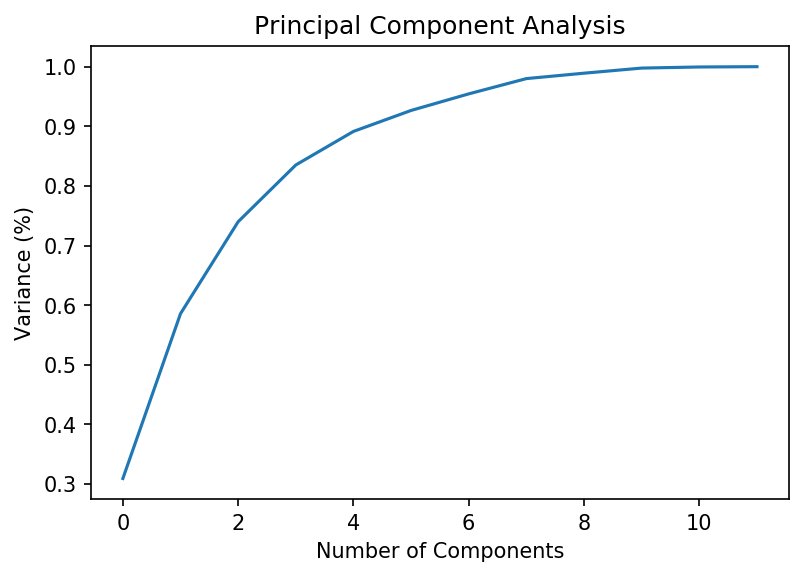

In [40]:
#Run Principal component analysis (PCA)
df_scaled = StandardScaler().fit_transform(df_main)
pca = PCA().fit(df_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Principal Component Analysis')
plt.show()

In [41]:
#pca = PCA(n_components=7)
pca = PCA(n_components=5)
dataset = pca.fit_transform(df_scaled)

Estimated number of clusters: 5
Estimated number of outlier / noise points: 41
Silhouette Coefficient: 0.300


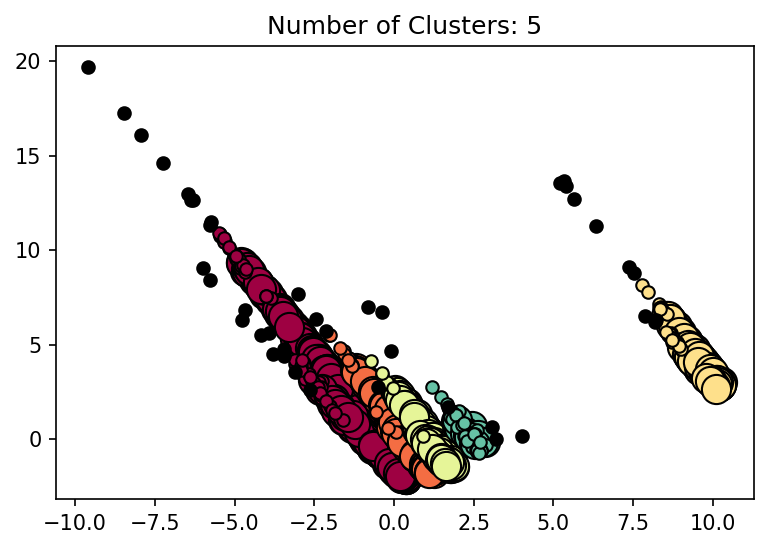

In [44]:
#Do the clustring using DBSCAN

from sklearn import metrics
dbscan = DBSCAN(eps=2.2, min_samples=50).fit(dataset)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
#print(core_samples_mask)
core_samples_mask[dbscan.core_sample_indices_] = True
#print(dbscan.core_sample_indices_)
#print(core_samples_mask[dbscan.core_sample_indices_])

labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
#print(labels)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of outlier / noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(dataset, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(df_scaled, labels))


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = dataset[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = dataset[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
plt.rcParams['figure.dpi'] = 150
plt.title('Number of Clusters: %d' % n_clusters_)
plt.show()

In [68]:

df['clusters'] = labels
df.to_sql('npi_outliers_opioid_day_supply_with_clusters', conn, if_exists='replace', index=False)

